# Non-Negative Matrix Factorization

##### Using NNMF to uncover spatial components of individual player contribution.

Heavily inspired by [Justin Jacobs](https://twitter.com/Squared2020) 2018 blog post [Understanding Trends in the NBA: How NNMF Works](https://squared2020.com/2018/10/04/understanding-trends-in-the-nba-how-nnmf-works/).

Non-negative matrix factorization (NNMF) is a very useful tool for dimensionality reduction of spatial distributions. In this notebooks, we use it to uncover areas of the field that individual players may operate in.

Perhaps think of these components as "roles" as opposed to "positions". An individual player may play a single position in a match, but they can fill multiple roles at once.

---

In [1]:
# This builds the soccerutils module in the Analytics Handbook so you can import it
!pip install git+https://github.com/devinpleuler/analytics-handbook.git

In [2]:
from soccerutils.statsbomb import get_events
from soccerutils.pitch import Pitch

In this example, we import `get_events` from the `soccerutils.statsbomb` module, which loads all events from a single competition/season into a simple list.

We also import the `Pitch` class from `soccerutils.pitch`, which we can use to plot field lines.

---

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [4]:
from sklearn.decomposition import NMF
from scipy.ndimage import gaussian_filter

We can import the `NMF` class from `sklean.decomposition`, which we use to create our NMF model.

We also import `gaussian_filter` from `scipy.ndimage`, which we use to smooth the resulting components of the model.

---

In [5]:
events = get_events(competition_id=43, season_id=3)

Get all 2018 World Cup events and put them into the events list.

---

In [6]:
x_scale, y_scale = 30, 20

x_bins = np.linspace(0, 120, x_scale)
y_bins = np.linspace(0, 80, y_scale)

These are the dimensions of the matrix we will be using. These are arbitrarily set, but I found they work pretty well given the sample size of this data set.

---

In [7]:
players = {}

for e in events:
    if 'player' in e.keys():
        player_id = e['player']['id']            
        if player_id not in players.keys():
            players[player_id] = np.zeros((x_scale, y_scale))
        try:
            x_bin = int(np.digitize(e['location'][0], x_bins[1:], right=True))
            y_bin = int(np.digitize(e['location'][1], y_bins[1:], right=True))
            players[player_id][x_bin][y_bin] += 1
        except:
            pass

This segment of code parses through all events, and populates the players dictionary with a matrix that represents spatially discributed cumulative actions a player generated in the data set.

The `np.digitize` function is a really useful function for binning events that occur on a continuous domain.

---

In [8]:
unraveled = [np.matrix.flatten(v) for k, v in players.items()]

This numpy matrix function flattens individual player matricies into `shape=(600,)` which is the product of the original shape components (30 by 20)

---

In [9]:
comps = 30
model = NMF(n_components=comps, init='random', random_state=0)
W = model.fit_transform(unraveled)

Here we set the number of components that we want to solve for. We've set it to `30`, which is mostly arbitrary.

We build the model using the `NMF` class, and fit it by feeding the unraveled matrix into `fit_transform`.

`random_state=0` is used for reproducability.

---

This section below plots each spatial component on top of a pitch provided by `soccerutils.Pitch`

Notice `np.rot90` rotating the individual matricies before plotting, because the field is layed out east-west.

And `guassian_blur` with `sigma=1.5` is providing a slight smoothing on top of the matrix.

The resulting matrix is fed into `ax.countourf`, which builds a contour plot on top of each field.

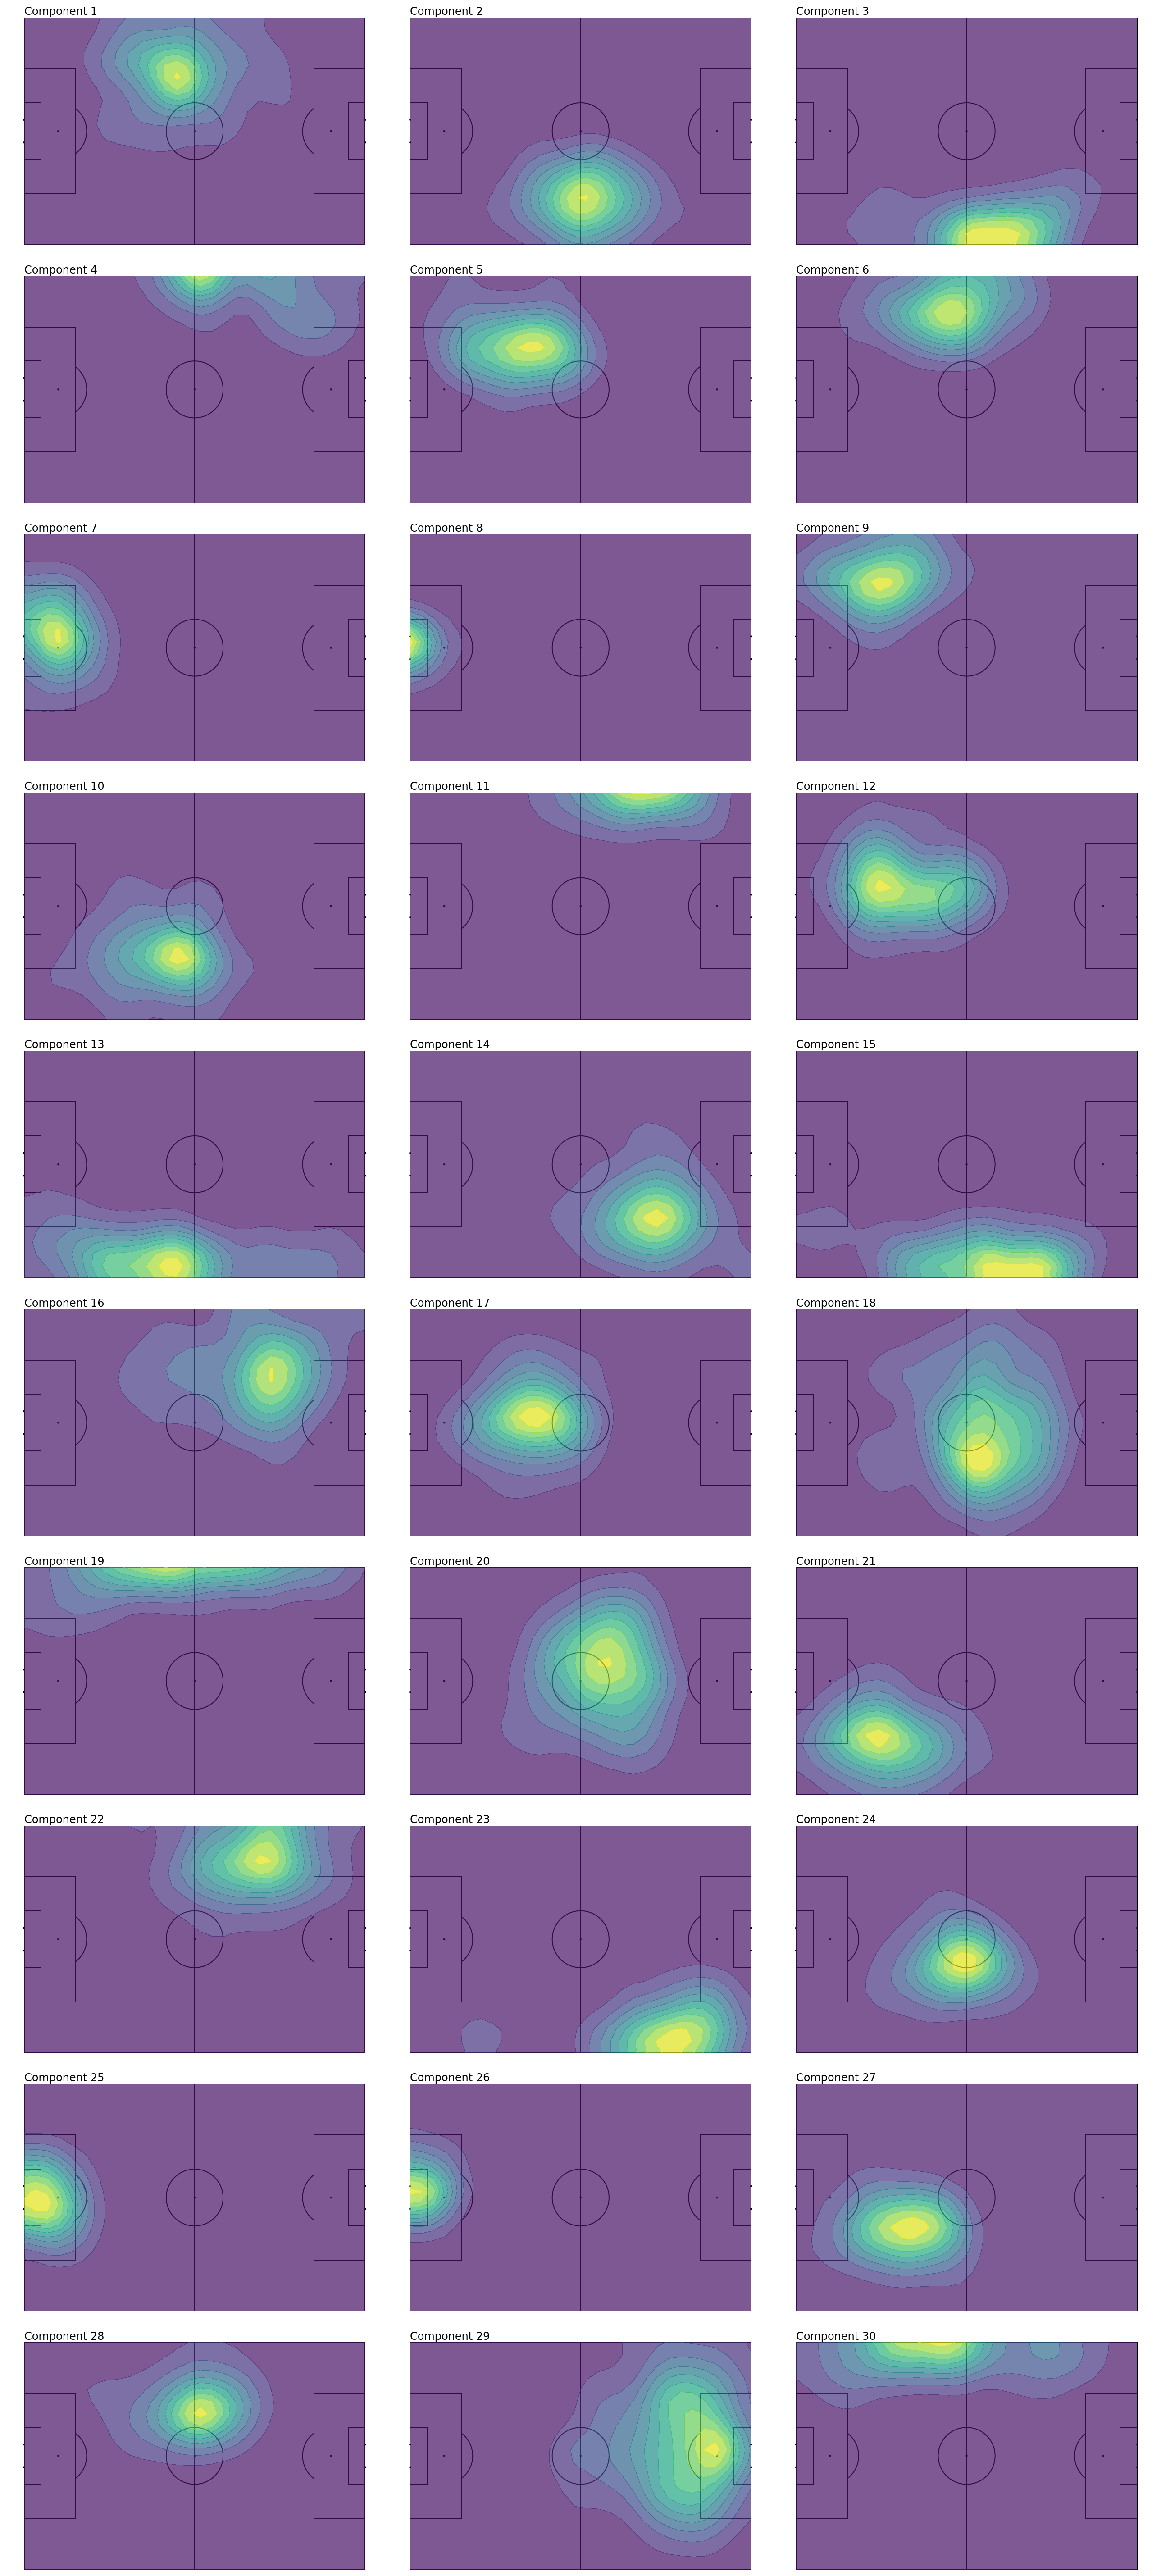

In [10]:
fig, axes = plt.subplots(10, 3, figsize=(18, 40))

for i in range(comps):
    ax = axes[i // 3][i % 3]

    pitch = Pitch(title="Component {}".format(i+1))
    pitch.create_pitch(ax)
    
    z = np.rot90(gaussian_filter(model.components_[i].reshape(x_scale, y_scale), sigma=1.5), 1)
    
    ax.contourf(x_bins, y_bins, z,
                zorder=2,
                levels=10,
                alpha=0.7,
                cmap='viridis')
    
    ax.set_aspect(1)
    ax.axis('off')

plt.tight_layout()
plt.show()

---

Devin Pleuler 2020